In [220]:
import json
import os
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from skimage.transform import resize
from collections import defaultdict, Counter
from math import log
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from itertools import chain
from pprint import pprint
import re
from autocorrect import spell

import spacy
from spacy import displacy
import en_core_web_sm

import nltk
from nltk.stem import WordNetLemmatizer

import keras.utils
from keras.applications import Xception
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Activation, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.layers import (concatenate)
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

data_dir = "C:\\Users\\MariLiis\\PycharmProjects\\PetFinderNN\\data"

sentiment_train_dir =  os.path.join(data_dir, "train_sentiment") 
sentiment_test_dir =  os.path.join(data_dir, "test_sentiment") 

train_image = os.path.join(data_dir, "train_images")
test_image = os.path.join(data_dir, "test_images")

label_column = "AdoptionSpeed"

BATCH_SIZE, test_size = 512, 0.2

height, width = 100, 100

nlp = en_core_web_sm.load()

## Data processing methods from ImagesCNN

In [54]:
def read_csv_kaggle(path, is_train, train_data=None):
    train = pd.read_csv(path, sep=',')
    pet_ids = train["PetID"]

    selected_columns = ["Type",
                        "Gender",
                        "Color1",
                        "Color2",
                        "Color3",
                        "MaturitySize",
                        "FurLength",
                        "Vaccinated",
                        "Dewormed",
                        "Sterilized",
                        "Health",
                        #"State",
                        "MaturitySize"]
    
    y = train[label_column] if is_train else None
    
    # One-Hot-encode
    X = pd.get_dummies(train[selected_columns], columns=selected_columns)

    # Normalize:
    to_normalize = ["Age", "Fee", "Quantity", "PhotoAmt"]
    
    if is_train:
        for to_norm in to_normalize:
             X[to_norm] = (train[to_norm] - train[to_norm].mean()) / train[to_norm].std()
    else:
        train_data = pd.read_csv(train_data, sep=',')
        for to_norm in to_normalize:
             X[to_norm] = (train[to_norm] - train_data[to_norm].mean()) / train_data[to_norm].std()
        
    
    return X, y, pet_ids

def read_images(image_paths):
    def random_image():
        return np.random.rand(height, width, 3) * 255
    
    def read_image(path):
        img = np.asarray(Image.open(path).convert("RGB"), dtype="int32" )
        return resize(img, (height, width), anti_aliasing=True, mode='constant')    

    return np.array([read_image(path) if os.path.isfile(path) else random_image() for path in tqdm(image_paths)])

def read_sentiment(pet_ids, sentiment_paths):
    magnitudes, scores = [], []
    
    for pet_id in tqdm(pet_ids):
        file_loc = os.path.join(sentiment_paths, "{}.json".format(pet_id))
        # check if there exists sentiment analysis for the pet, else set scores 0.0
        if os.path.isfile(file_loc):
            with open(file_loc, encoding="UTF-8", mode="r") as json_file:  
                data = json.load(json_file)
                magnitude,score = data["documentSentiment"]["magnitude"], data["documentSentiment"]["score"]
        else:
            magnitude, score = 0.0, 0.0
    
        magnitudes.append(magnitude)
        scores.append(score)
    return magnitudes, scores

In [55]:
X, y, pet_ids = read_csv_kaggle(os.path.join(data_dir, "train.csv"), True)
X["sent_magnitude"], X["sent_score"] = read_sentiment(pet_ids, sentiment_train_dir)

100%|████████████████████████████████████| 14993/14993 [03:30<00:00, 71.07it/s]


In [10]:
f_im_name = "images.binary"

if not os.path.isfile(f_im_name):
    images = read_images([os.path.join(train_image, pet_id + "-1.jpg") for pet_id in pet_ids])
    
    # Standardize:
    mean, std = np.mean(images), np.std(images)
    images_meanstd = (images - mean)/std
    
    with open(f_im_name, 'wb') as handle_1, open("mnstd", 'wb') as handle_2:
        pickle.dump(images_meanstd, handle_1, protocol=pickle.HIGHEST_PROTOCOL)        
        pickle.dump((mean, std), handle_2, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(f_im_name, 'rb') as handle_1, open("mnstd", 'rb') as handle_2:
        images_meanstd = pickle.load(handle_1)
        temp = pickle.load(handle_2)
        mean, std = temp[0], temp[1]
                
print(images_meanstd.shape)

100%|████████████████████████████████████| 14993/14993 [16:28<00:00, 16.74it/s]


MemoryError: 

In [56]:
X_train_img, X_test_img, X_train_else, X_test_else, y_train, y_test = train_test_split(images_meanstd, 
                                                                                       X, 
                                                                                       y, 
                                                                                       test_size=test_size,
                                                                                       random_state=1)

## Using only image data

In [48]:
# https://towardsdatascience.com/image-classifier-cats-vs-dogs-with-convolutional-neural-networks-cnns-and-google-colabs-4e9af21ae7a8https://towardsdatascience.com/image-classifier-cats-vs-dogs-with-convolutional-neural-networks-cnns-and-google-colabs-4e9af21ae7a8
input_shape = X_train_img[0].shape
image_input = Input(shape=(height, width, 3))

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(256, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(256, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation("relu"))
# model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation("softmax"))


model.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=0.0001),
              metrics=["accuracy"])

history = model.fit(X_train_img, 
                    keras.utils.to_categorical(y_train),
                    batch_size=BATCH_SIZE, 
                    epochs=4, 
                    validation_split=0.1,
                    callbacks=[ModelCheckpoint('test_model.h5', save_best_only=True)])

Train on 10794 samples, validate on 1200 samples
Epoch 1/4
10794/10794 [==============================] - ETA: 3:43 - loss: 1.6003 - acc: 0.216 - ETA: 2:39 - loss: 1.6084 - acc: 0.210 - ETA: 2:07 - loss: 1.5958 - acc: 0.238 - ETA: 1:57 - loss: 1.5917 - acc: 0.245 - ETA: 1:46 - loss: 1.5861 - acc: 0.244 - ETA: 1:42 - loss: 1.5784 - acc: 0.261 - ETA: 1:38 - loss: 1.5724 - acc: 0.260 - ETA: 1:28 - loss: 1.5673 - acc: 0.266 - ETA: 1:19 - loss: 1.5644 - acc: 0.263 - ETA: 1:11 - loss: 1.5597 - acc: 0.261 - ETA: 1:06 - loss: 1.5546 - acc: 0.262 - ETA: 59s - loss: 1.5502 - acc: 0.264 - ETA: 54s - loss: 1.5454 - acc: 0.26 - ETA: 47s - loss: 1.5435 - acc: 0.26 - ETA: 41s - loss: 1.5402 - acc: 0.26 - ETA: 34s - loss: 1.5389 - acc: 0.26 - ETA: 28s - loss: 1.5357 - acc: 0.26 - ETA: 21s - loss: 1.5337 - acc: 0.26 - ETA: 14s - loss: 1.5306 - acc: 0.26 - ETA: 7s - loss: 1.5281 - acc: 0.2666 - ETA: 0s - loss: 1.5265 - acc: 0.266 - 157s 15ms/step - loss: 1.5266 - acc: 0.2664 - val_loss: 1.4825 - val_acc

## Images + sentiment

We can tag words by their type with nltk.pos_tag

In [75]:
with open("C:\\Users\\MariLiis\\PycharmProjects\\PetFinderNN\\data\\train_sentiment\\00ac364a4.json", encoding="UTF-8", mode="r") as json_file:  
    data = json.load(json_file)
    sentences = data["sentences"]
    for sent in sentences:
        print(nltk.pos_tag(nltk.word_tokenize(sent['text']['content'])))

[('My', 'PRP$'), ('friend', 'NN'), ('and', 'CC'), ('I', 'PRP'), ('have', 'VBP'), ('brought', 'VBN'), ('her', 'PRP'), ('to', 'TO'), ('the', 'DT'), ('vet', 'NN'), ('and', 'CC'), ('she', 'PRP'), ('is', 'VBZ'), ('currently', 'RB'), ('being', 'VBG'), ('taken', 'VBN'), ('care', 'NN'), ('of', 'IN'), ('a', 'DT'), ('foster', 'NN'), ('.', '.')]
[('She', 'PRP'), ('will', 'MD'), ('be', 'VB'), ('well', 'RB'), ('in', 'IN'), ('about', 'RB'), ('two', 'CD'), ('months', 'NNS'), ("'", 'POS'), ('time', 'NN'), ('and', 'CC'), ('all', 'DT'), ('ready', 'JJ'), ('for', 'IN'), ('adoption', 'NN'), ('!', '.')]
[('Please', 'NNP'), ('do', 'VBP'), ("n't", 'RB'), ('hesitate', 'VB'), ('to', 'TO'), ('ask', 'VB'), ('any', 'DT'), ('more', 'JJR'), ('questions', 'NNS'), ('.', '.')]
[('For', 'IN'), ('more', 'JJR'), ('information', 'NN'), (':', ':')]


and we can use spacy to extract names from the text.

In [152]:
with open("C:\\Users\\MariLiis\\PycharmProjects\\PetFinderNN\\data\\train_sentiment\\00f3a3993.json", encoding="UTF-8", mode="r") as json_file:  
    data = json.load(json_file)
    sentences = data["sentences"]
    for sent in sentences:
        doc = nlp(sent['text']['content'])
        pprint([(X.text, X.label_) for X in doc.ents])

[('Terry', 'PERSON')]
[]
[]
[('Jocelyn', 'PERSON')]
[]
[('2', 'CARDINAL')]
[]


In [167]:
nlp('Mary looked there and saw Jack').ents

(Mary, Jack)

In [72]:
nltk.help.upenn_tagset()  # all the nltk tags explained

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [171]:
# Create dictionary class -> list<word> 
# where class = 0..4 
# and words in word_dict[i] are all meaningful words in the pet descriptions of samples in class i
# meaningful -- only contain latin letters, do not contain numbers or special symbols, are not articles etc.
def read_sentiment_2(pet_ids, sentiment_paths, y):
    magnitudes, scores = [], []
    lemmatizer = WordNetLemmatizer() 
    word_dict = defaultdict(list)
    
    i = 0
    for pet_id in tqdm(pet_ids):
        file_loc = os.path.join(sentiment_paths, "{}.json".format(pet_id))
        # check if there exists sentiment analysis for the pet, else set scores 0.0
        if os.path.isfile(file_loc):
            with open(file_loc, encoding="UTF-8", mode="r") as json_file:  
                data = json.load(json_file)
                sentences = data["sentences"]
                for sent in sentences:
                    content, sentiment = sent['text']['content'], sent['sentiment']
                    tagged_words = nltk.pos_tag(nltk.word_tokenize(content))
                    extracted_names = [x.text for x in nlp(content).ents]
                    tagged_words = filter(lambda x: x[1] in ["FW", "JJ", "JJR", "JJS", "NN", "NNP", "NNPS", "NNS",
                                                             "RB", "RBR", "RBS", "UH", "VB", "VBD", "VBG", "VBN", 
                                                             "VBP", "VBZ"] and x[0] not in extracted_names, tagged_words)
                    lemmatized = map(lambda x: lemmatizer.lemmatize(x[0]), tagged_words)
                    target_class = y.iloc[i]
                    word_dict[target_class] += lemmatized
        i += 1
                    
    
    return word_dict

In [172]:
word_dict = read_sentiment_2(pet_ids, sentiment_train_dir, y)

100%|████████████████████████████████████| 14993/14993 [30:34<00:00,  7.87it/s]


In [269]:
for k in word_dict:
    word_dict[k] = list(map(lambda x: x.lower(), word_dict[k]))

In [173]:
# pickle.dump(word_dict, open("word_dict_1.p", "wb"))

We can look at the word clouds of each class. 

In [270]:
def display_wordcloud(target, word_dict=word_dict):
    wordcloud = WordCloud().generate(" ".join(word_dict[target]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

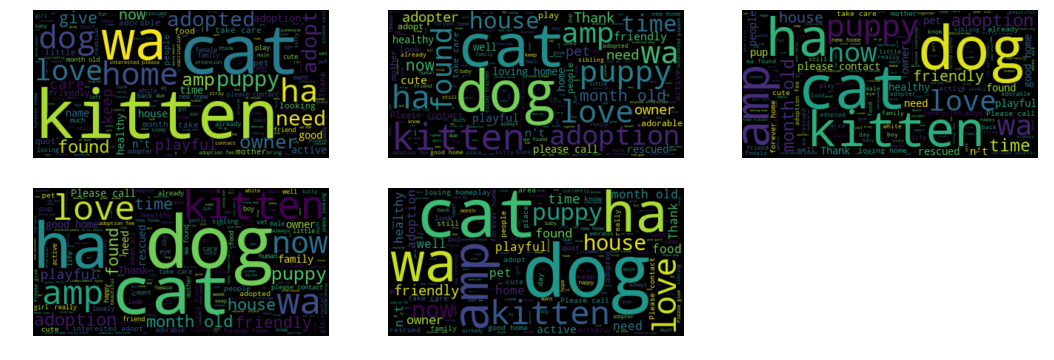

In [175]:
plt.rcParams['figure.figsize'] = [18, 6] # width x height (inch)
for target in range(5):
    plt.subplot(2, 3, target + 1)
    display_wordcloud(target)

In [90]:
# The number of words in each class, names included
for k in word_dict.keys():
    print(len(word_dict[k]))

154222
13335
133533
114622
144828


In [176]:
# The number of words in each class, names NOT included
for k in word_dict.keys():
    print(len(word_dict[k]))

149334
12886
129099
110915
140371


In [291]:
# Creates a dictionary class -> word -> tf-idf score
def tf_idf(word_dict=word_dict):
    counter_dict = {}
    tf_idf_dict = defaultdict(dict)
    n_docs = len(word_dict.keys())
    doc_counts = defaultdict(int)
    all_words = set(chain(*word_dict.values()))
    
    for k in word_dict:
        counter_dict[k] = Counter(word_dict[k])
        for word in set(word_dict[k]):
            doc_counts[word] += 1
    
    for k in word_dict:
        max_freq = sorted(counter_dict[k].items(), key=lambda x: x[1], reverse=True)[0][1]
        for word in set(word_dict[k]):
            if counter_dict[k][word] > 3:
                tf = 0.5 + 0.5 * (counter_dict[k][word] / max_freq)
                idf = log(n_docs / doc_counts[word])
                tf_idf_dict[k][word] = tf * idf

        
    return tf_idf_dict

In [292]:
tf_idf_scores = tf_idf()

In [306]:
list(Counter(word_dict[0]).items())[:10]

[('just', 37),
 ('found', 63),
 ('alone', 8),
 ('apartment', 12),
 ('wa', 132),
 ('shaking', 1),
 ('so', 64),
 ('had', 28),
 ('bring', 19),
 ('home', 170)]

In [307]:
list(tf_idf_scores[0].items())[:10]

[('allowed', 0.0),
 ('away', 0.0),
 ("'re", 0.0),
 ('time', 0.0),
 ('@', 0.0),
 ('lover', 0.0),
 ('neighbour', 0.0),
 ('rescue', 0.0),
 ('more', 0.0),
 ('characteristic', 0.0)]

In [293]:
def filter_words(word):
    if word[0].isupper():
        return False
    elif re.match("^[a-zA-Z_][a-zA-Z_]*$", word) is None:
        return False
    exclude = ["www", ".", "+", "/", "scooby", "pepsi", "acidently", "happines", "sean", "ooooo", "entitles", "hapily", "ahhh",
               "brandee"]
    return not any(map(lambda x: x in word, exclude))

In [294]:
for k in range(5):
    sorted_scores = sorted(tf_idf_scores[k].items(), key=lambda x: x[1], reverse=True)
    sorted_scores = list(filter(lambda x: filter_words(x[0]), sorted_scores))
    print(sorted_scores[:20])

[('facilitate', 0.8119039468975595), ('entitled', 0.8119039468975595), ('tut', 0.4642812413737349), ('mochi', 0.46325859546762527), ('substitute', 0.25826340130133235), ('shaila', 0.25769328341766495), ('lrt', 0.11281699636756364), ('bro', 0.11256795222547189), ('allowed', 0.0), ('away', 0.0), ('time', 0.0), ('lover', 0.0), ('neighbour', 0.0), ('rescue', 0.0), ('more', 0.0), ('characteristic', 0.0), ('feeding', 0.0), ('manja', 0.0), ('quot', 0.0), ('f', 0.0)]
[('mosu', 0.8069062868944545), ('guinevere', 0.8064688207589736), ('befriended', 0.8058126215557523), ('poody', 0.8058126215557523), ('marschia', 0.8055938884880118), ('izzy', 0.8055938884880118), ('haru', 0.8055938884880118), ('gumby', 0.8055938884880118), ('puff', 0.8055938884880118), ('jem', 0.8055938884880118), ('friska', 0.8055938884880118), ('deemed', 0.8055938884880118), ('munky', 0.8055938884880118), ('olly', 0.8055938884880118), ('metropoint', 0.8055938884880118), ('handphone', 0.8055938884880118), ('lok', 0.8055938884880

In [295]:
def gather_significant_words(tf_idf_scores, w_per_cat=10):
    words = []
    for k in tf_idf_scores:
        sorted_scores = sorted(tf_idf_scores[k].items(), key=lambda x: x[1], reverse=True)
        sorted_scores = filter(lambda x: filter_words(x[0]) and x[1] > 0.5, sorted_scores)
        words += list(map(lambda x: x[0], sorted_scores))[:w_per_cat]
    
    return list(set(words))

In [225]:
spell('happines')

'happiness'

In [296]:
significant_words = gather_significant_words(tf_idf_scores)
len(significant_words)

42

In [77]:
X.columns

Index(['Type_1', 'Type_2', 'Gender_1', 'Gender_2', 'Gender_3', 'Color1_1',
       'Color1_2', 'Color1_3', 'Color1_4', 'Color1_5', 'Color1_6', 'Color1_7',
       'Color2_0', 'Color2_2', 'Color2_3', 'Color2_4', 'Color2_5', 'Color2_6',
       'Color2_7', 'Color3_0', 'Color3_3', 'Color3_4', 'Color3_5', 'Color3_6',
       'Color3_7', 'MaturitySize_1', 'MaturitySize_2', 'MaturitySize_3',
       'MaturitySize_4', 'MaturitySize_1', 'MaturitySize_2', 'MaturitySize_3',
       'MaturitySize_4', 'FurLength_1', 'FurLength_2', 'FurLength_3',
       'Vaccinated_1', 'Vaccinated_2', 'Vaccinated_3', 'Dewormed_1',
       'Dewormed_2', 'Dewormed_3', 'Sterilized_1', 'Sterilized_2',
       'Sterilized_3', 'Health_1', 'Health_2', 'Health_3', 'MaturitySize_1',
       'MaturitySize_2', 'MaturitySize_3', 'MaturitySize_4', 'MaturitySize_1',
       'MaturitySize_2', 'MaturitySize_3', 'MaturitySize_4', 'Age', 'Fee',
       'Quantity', 'PhotoAmt', 'sent_magnitude', 'sent_score'],
      dtype='object')

In [303]:
def add_significant_words(pet_ids, sentiment_paths, X, sign_words, add_magn_scores=True):
    magnitudes, scores = [], []
    lemmatizer = WordNetLemmatizer() 
    word_dict = defaultdict(list)
    sign_word_counts = defaultdict(list)
    
    for pet_id in tqdm(pet_ids):
        file_loc = os.path.join(sentiment_paths, "{}.json".format(pet_id))
        # check if there exists sentiment analysis for the pet, else set scores 0.0
        if os.path.isfile(file_loc):
            with open(file_loc, encoding="UTF-8", mode="r") as json_file:  
                data = json.load(json_file)
                sentences = data["sentences"]
                full_content = ""
                for sent in sentences:
                    content = sent['text']['content']
                    full_content += (" " + content)
                
                tagged_words = nltk.pos_tag(nltk.word_tokenize(content))
                lemmatized = map(lambda x: lemmatizer.lemmatize(x[0]).lower(), tagged_words)
                lemmatized_counts = Counter(lemmatized)
                for s_w in sign_words:
                    count = 0 if s_w not in lemmatized_counts else lemmatized_counts[s_w]
                    sign_word_counts[s_w].append(count)

                if add_magn_scores:
                    magnitude,score = data["documentSentiment"]["magnitude"], data["documentSentiment"]["score"]
        else:
            if add_magn_scores:
                magnitude, score = 0.0, 0.0
            
            for s_w in sign_words:
                sign_word_counts[s_w].append(0)

        if add_magn_scores:
            magnitudes.append(magnitude)
            scores.append(score)
        
    
    assert len(sign_word_counts) == len(sign_words), "Not the same amount of significant words!"
    for s_w in sign_word_counts:
        print(s_w)
        assert len(sign_word_counts[s_w]) == len(X), "Not the same amount of instances!"
        X[s_w] = sign_word_counts[s_w]
        
    if add_magn_scores:
        X["sent_magnitude"], X["sent_score"] = magnitudes, scores
    
    return X

In [298]:
X_significant_words = add_significant_words(pet_ids, sentiment_train_dir, X, significant_words)

100%|███████████████████████████████████| 14993/14993 [00:58<00:00, 254.72it/s]


rooms
allowable
marschia
jem
suicide
organic
mel
flyover
reika
japped
champion
catered
sultan
tora
haru
ean
mosu
poody
abode
cozy
gua
zee
estee
kunyuk
alertness
pea
entitled
tto
incapacitated
fruitcake
wai
stewie
puff
gumby
mumy
kiseki
izzy
miaw
facilitate
filo
befriended
guinevere


In [302]:
X_significant_words.rooms.value_counts()

0    14993
Name: rooms, dtype: int64

In [308]:
X_train_img, X_test_img, X_train_else, X_test_else, y_train, y_test = train_test_split(images_meanstd, 
                                                                                       X, 
                                                                                       y, 
                                                                                       test_size=test_size,
                                                                                       random_state=1)

MemoryError: 

In [309]:
# https://stackoverflow.com/questions/49618986/neural-network-in-keras-with-two-different-input-types-images-and-values
# https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/

transfer = Xception(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Freeze Xception
for layer in transfer.layers[:-3]:
    layer.trainable = False

# Inputs
image_input = Input(shape=(height, width, 3))
aux_input = Input(shape=(len(list(X_train_else)),))

# Images:
transfer = transfer(image_input)
flatten = Flatten()(transfer)

# Aux input:
x = Dense(250, activation='relu')(aux_input)
x = Dense(350, activation='relu')(x)
x = Dense(450, activation='relu')(x)
x = Dense(700, activation='relu')(x)

# Merged:
merge = concatenate([flatten, x])
x = Dense(100, activation='relu')(merge)
h = Dense(5, activation='relu')(x)

# Predictions:
predictions = Activation('softmax')(h)

model = Model(inputs=[image_input, aux_input], outputs=predictions)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit([X_train_img, X_train_else], 
                    keras.utils.to_categorical(y_train),
                    batch_size=BATCH_SIZE, 
                    epochs=4, 
                    validation_split=0.1,
                    callbacks=[ModelCheckpoint('test_model.h5', save_best_only=True)])

20914176/83683744 [======>.......................] - ETA: 44:5 - ETA: 29:1 - ETA: 26:5 - ETA: 25:0 - ETA: 23:5 - ETA: 22:2 - ETA: 21:4 - ETA: 20:2 - ETA: 19:3 - ETA: 19:1 - ETA: 18:3 - ETA: 18:1 - ETA: 18:1 - ETA: 17:5 - ETA: 17:2 - ETA: 18:0 - ETA: 16:2 - ETA: 17:0 - ETA: 17:5 - ETA: 17:1 - ETA: 17:5 - ETA: 17:4 - ETA: 17:5 - ETA: 18:0 - ETA: 17:4 - ETA: 18:1 - ETA: 18:0 - ETA: 18:1 - ETA: 18:0 - ETA: 18:1 - ETA: 18:0 - ETA: 18:0 - ETA: 17:3 - ETA: 17:4 - ETA: 17:3 - ETA: 17:2 - ETA: 17:1 - ETA: 17:0 - ETA: 16:5 - ETA: 16:4 - ETA: 16:2 - ETA: 16:2 - ETA: 16:1 - ETA: 16:0 - ETA: 15:5 - ETA: 15:4 - ETA: 15:3 - ETA: 15:2 - ETA: 15:0 - ETA: 15:0 - ETA: 15:1 - ETA: 14:5 - ETA: 14:4 - ETA: 14:4 - ETA: 14:3 - ETA: 14:2 - ETA: 14:1 - ETA: 14:1 - ETA: 14:0 - ETA: 14:0 - ETA: 13:5 - ETA: 13:4 - ETA: 13:4 - ETA: 13:3 - ETA: 13:2 - ETA: 13:2 - ETA: 13:1 - ETA: 13:1 - ETA: 13:0 - ETA: 13:0 - ETA: 12:5 - ETA: 12:4 - ETA: 12:4 - ETA: 12:3 - ETA: 12:3 - ETA: 12:2 - ETA: 12:2 - ETA: 12:1 - ETA: 12:1 -

61554688/83683744 [=====================>........] - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3:

83689472/83683744 [==============================] - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2:

## Results visualized

Text(0.5, 1.0, 'Accuracy')

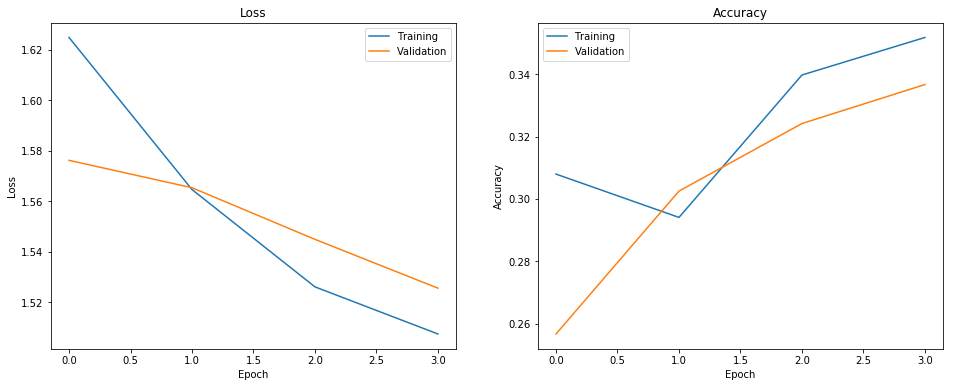

In [310]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [312]:
train_pred = [np.argmax(pred) for pred in model.predict([X_train_img, X_train_else])]
test_pred = [np.argmax(pred) for pred in model.predict([X_test_img, X_test_else])]

In [313]:
print("Kappa on train: {}".format(round(cohen_kappa_score(y_train, train_pred, weights="quadratic"), 4)))
print("Accuracy on train: {}".format(round(accuracy_score(y_train, train_pred), 4)))
print("________________")
print("Kappa on test: {}".format(round(cohen_kappa_score(y_test, test_pred, weights="quadratic"), 4)))
print("Accuracy on test: {}".format(round(accuracy_score(y_test, test_pred), 4)))

Kappa on train: 0.2511
Accuracy on train: 0.3618
________________
Kappa on test: 0.2048
Accuracy on test: 0.3351


## Kaggle Test

In [315]:
test, _, test_pet_ids = read_csv_kaggle(os.path.join(data_dir, "test.csv"), False, os.path.join(data_dir, "train.csv"))
# test["sent_magnitude"], test["sent_score"] = read_sentiment(test_pet_ids, sentiment_test_dir)
test = add_significant_words(test_pet_ids, sentiment_test_dir, test, significant_words)
test_images = read_images([os.path.join(test_image, pet_id + "-1.jpg") for pet_id in test_pet_ids])
test_images_std = (test_images - mean)/std

100%|██████████████████████████████████████| 3972/3972 [00:48<00:00, 81.06it/s]


rooms
allowable
marschia
jem
suicide
organic
mel
flyover
reika
japped
champion
catered
sultan
tora
haru
ean
mosu
poody
abode
cozy
gua
zee
estee
kunyuk
alertness
pea
entitled
tto
incapacitated
fruitcake
wai
stewie
puff
gumby
mumy
kiseki
izzy
miaw
facilitate
filo
befriended
guinevere


100%|██████████████████████████████████████| 3972/3972 [04:44<00:00, 11.68it/s]


In [ ]:
loaded = load_model('test_model.h5')
test_pred = loaded.predict([test_images_std, test])
test_pred_label = [np.argmax(pred) for pred in test_pred]
pd.DataFrame({'PetID': test_pet_ids, 'AdoptionSpeed': test_pred_label}).to_csv('neural.csv', index=False)